# Mô hình hóa Rủi ro Riêng lẻ (Marginal Risk Modeling)

Notebook này thực hiện các bước mô hình hóa rủi ro riêng lẻ cho từng cổ phiếu, bao gồm:
- Fit mô hình GARCH(1,1) với phân phối Student's t để mô hình hóa biến động.
- Kiểm tra chẩn đoán phần dư chuẩn hóa từ mô hình GARCH.
- Mô hình hóa rủi ro cực đoan (EVT) cho phần đuôi của phần dư chuẩn hóa.

## 1. Import thư viện và các hàm mô hình hóa

Import các thư viện cần thiết và các hàm đã xây dựng trong module `modeling.py`.

In [8]:
import pandas as pd
import numpy as np
import sys
from scipy.stats import genpareto
import matplotlib.pyplot as plt
sys.path.append('../src')
from modeling import fit_garch_t, diagnostic_residuals, fit_evt

## 2. Đọc dữ liệu log returns và chuẩn hóa tỷ lệ

Đọc dữ liệu log returns đã xử lý từ bước EDA.  
Để phù hợp với thông lệ tài chính, log returns được nhân với 100 (chuyển sang đơn vị phần trăm).

In [2]:
log_returns = pd.read_csv("../data/processed/log_returns.csv", index_col=0)
print("Loaded log_returns shape:", log_returns.shape)

 # Scale log returns (nếu muốn)
log_returns_scaled = log_returns * 100

Loaded log_returns shape: (2776, 5)


## 3. Fit mô hình GARCH(1,1) với Student's t cho từng cổ phiếu

Tiến hành fit mô hình GARCH(1,1) với phân phối Student's t cho từng chuỗi lợi suất.  
Kết quả trả về gồm:
- Đối tượng kết quả mô hình GARCH cho từng mã.
- Chuỗi phần dư chuẩn hóa (standardized residuals) cho từng mã.

In [3]:
garch_results, std_resids = fit_garch_t(log_returns_scaled)

Fitting GARCH for FPT_DATA...
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                     FPT_DATA   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -4871.52
Distribution:      Standardized Student's t   AIC:                           9753.05
Method:                  Maximum Likelihood   BIC:                           9782.69
                                              No. Observations:                 2776
Date:                      Wed, Aug 27 2025   Df Residuals:                     2775
Time:                              19:25:37   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-------------------------------------------------------

## 4. Kiểm tra chẩn đoán phần dư chuẩn hóa

Kiểm tra chất lượng phần dư chuẩn hóa bằng các kiểm định:
- ARCH test: Kiểm tra còn hiện tượng ARCH không.
- Ljung-Box test: Kiểm tra còn tự tương quan không.
- Thực hiện trên cả phần dư và phần dư bình phương.
Kỳ vọng các p-value lớn hơn 0.05, cho thấy phần dư đã "sạch".

In [4]:
diag_results = diagnostic_residuals(std_resids, lags=10, plot=True)

FPT_DATA: ARCH p=0.598, Ljung-Box p=0.883, ARCH^2 p=0.963, Ljung-Box^2 p=0.620
HPG_DATA: ARCH p=0.811, Ljung-Box p=0.472, ARCH^2 p=0.969, Ljung-Box^2 p=0.813
MWG_DATA: ARCH p=0.056, Ljung-Box p=0.001, ARCH^2 p=0.730, Ljung-Box^2 p=0.043
VCB_DATA: ARCH p=1.000, Ljung-Box p=0.818, ARCH^2 p=1.000, Ljung-Box^2 p=1.000
VIC_DATA: ARCH p=1.000, Ljung-Box p=0.556, ARCH^2 p=1.000, Ljung-Box^2 p=1.000


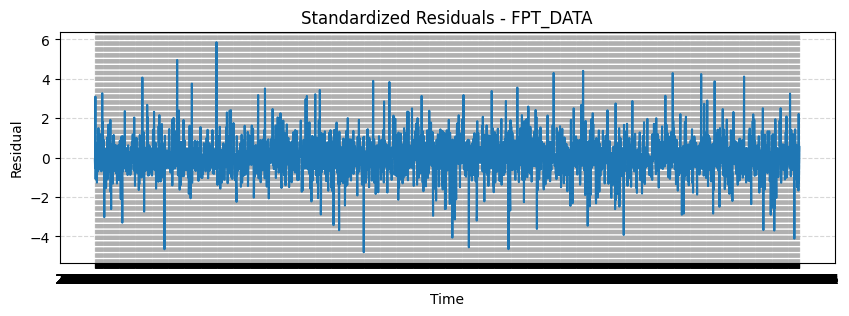

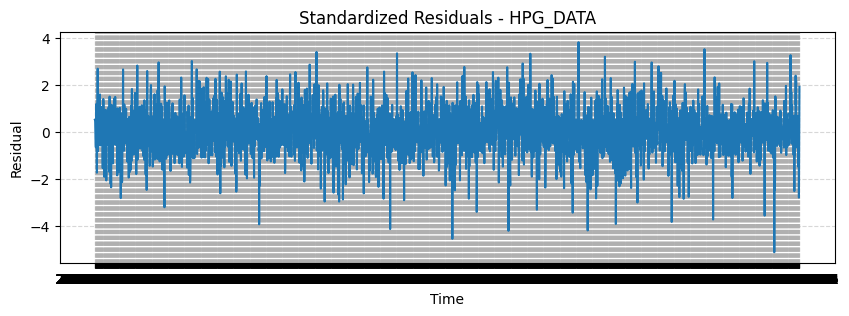

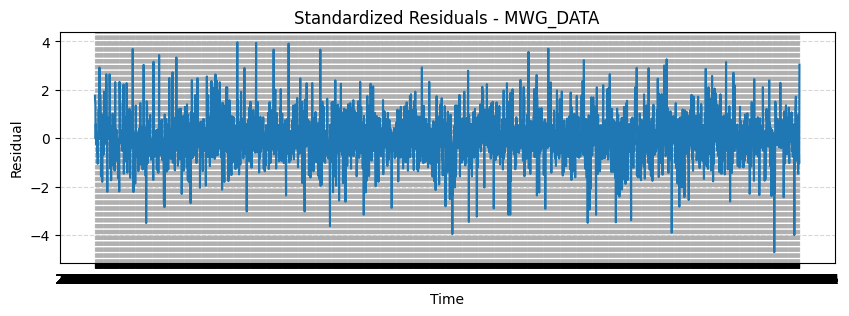

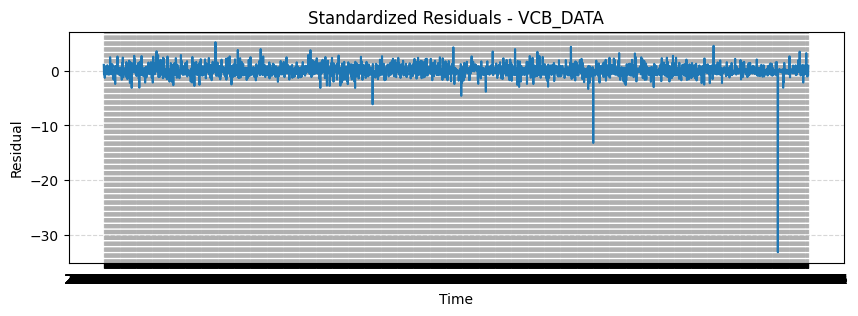

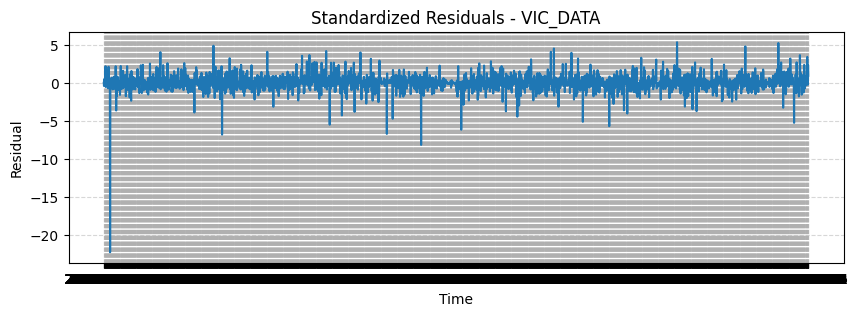

In [5]:
for ticker, resid in std_resids.items():
    plt.figure(figsize=(10, 3))
    plt.plot(resid)
    plt.title(f'Standardized Residuals - {ticker}')
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

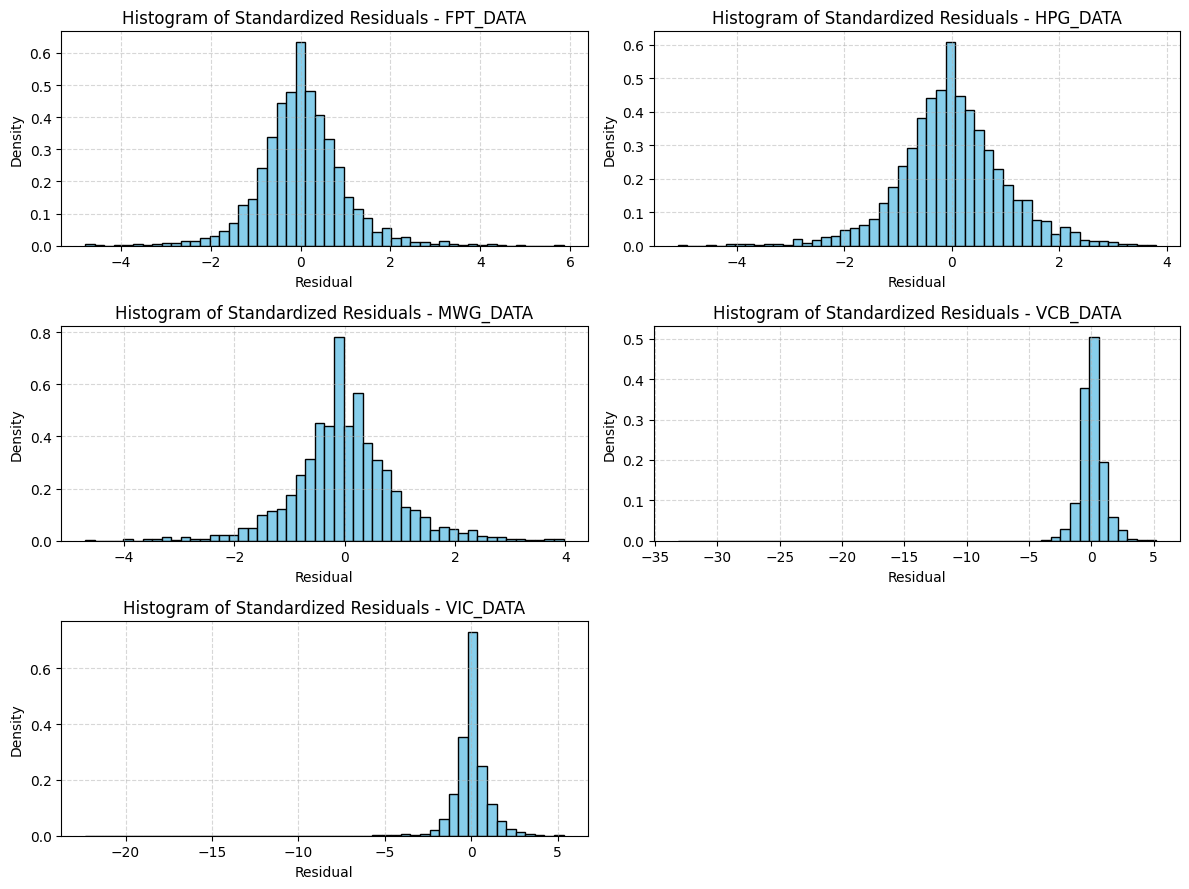

In [12]:
import math

n = len(std_resids)
cols = 2
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 3), sharex=False)
axes = axes.flatten()

for i, (ticker, resid) in enumerate(std_resids.items()):
    axes[i].hist(resid, bins=50, color='skyblue', edgecolor='black', density=True)
    axes[i].set_title(f'Histogram of Standardized Residuals - {ticker}')
    axes[i].set_xlabel('Residual')
    axes[i].set_ylabel('Density')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Ẩn các subplot thừa nếu có
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

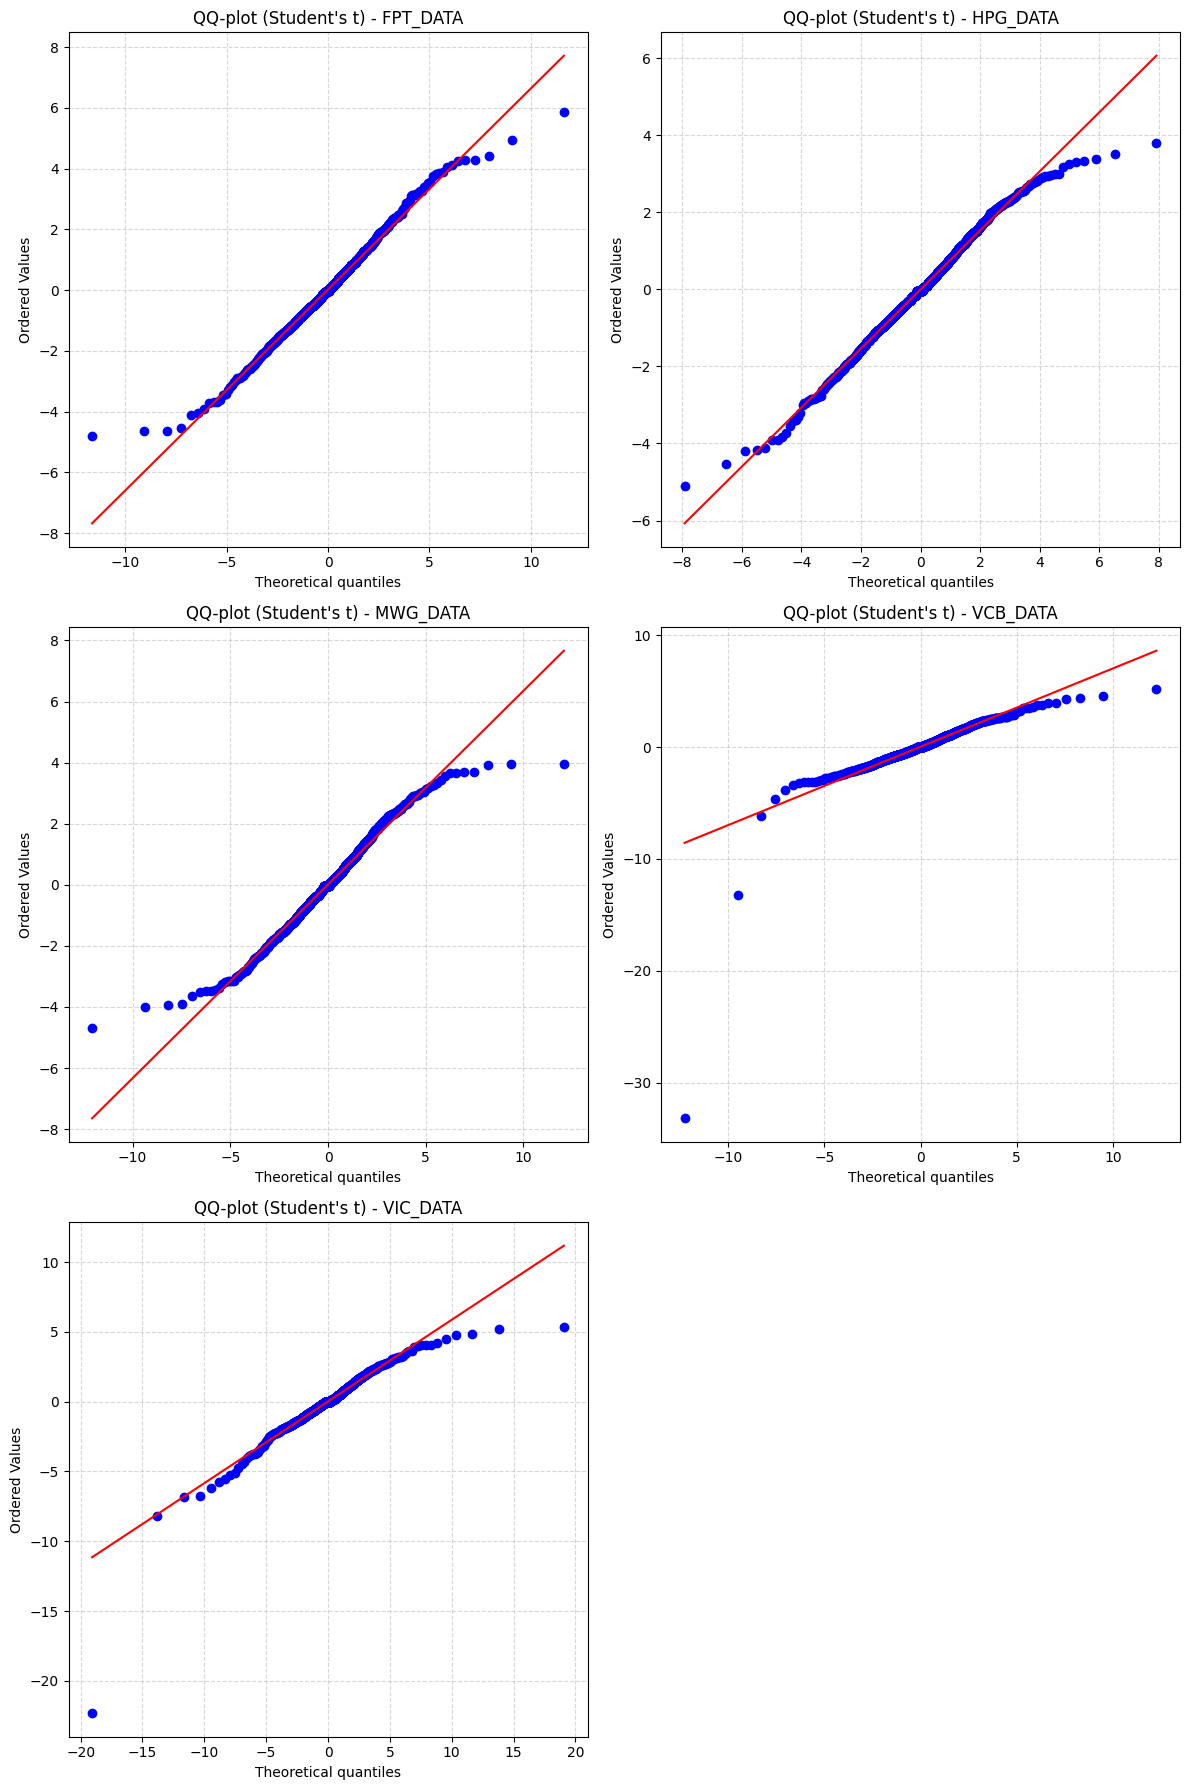

In [13]:
import math
from scipy.stats import probplot

n = len(std_resids)
cols = 2
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6), sharex=False)
axes = axes.flatten()

for i, (ticker, resid) in enumerate(std_resids.items()):
    probplot(resid, dist="t", sparams=(garch_results[ticker].params['nu'],), plot=axes[i])
    axes[i].set_title(f"QQ-plot (Student's t) - {ticker}")
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Ẩn các subplot thừa nếu có
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## 5. Mô hình hóa rủi ro cực đoan (EVT) cho phần dư chuẩn hóa

Áp dụng Extreme Value Theory (EVT) cho phần đuôi âm (lỗ lớn) của phần dư chuẩn hóa:
- Chọn ngưỡng (quantile 95%).
- Fit phân phối Pareto tổng quát (GPD) cho các giá trị vượt ngưỡng.
- Lưu lại các tham số threshold, shape, scale cho từng mã.

EVT for FPT_DATA: threshold=1.4125, shape=0.0949, scale=0.6542
EVT for HPG_DATA: threshold=1.5689, shape=-0.0059, scale=0.6854
EVT for MWG_DATA: threshold=1.4867, shape=0.0167, scale=0.6364
EVT for VCB_DATA: threshold=1.3493, shape=0.3088, scale=0.5721
EVT for VIC_DATA: threshold=1.3629, shape=0.5190, scale=0.5228


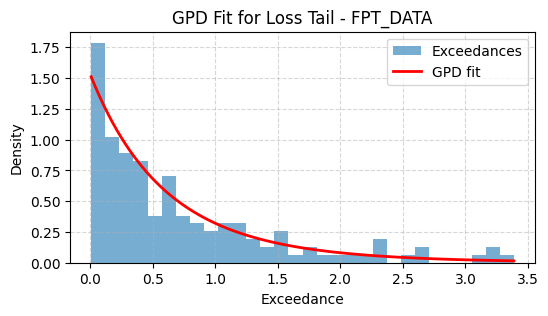

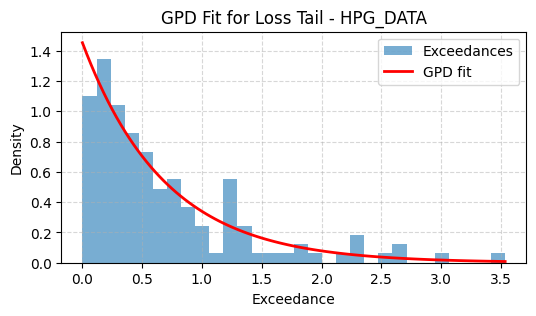

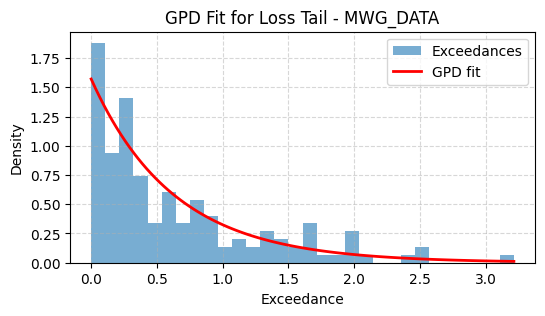

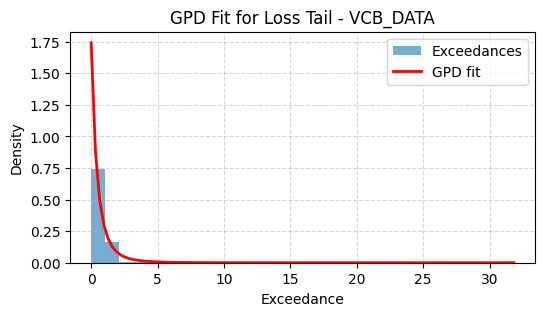

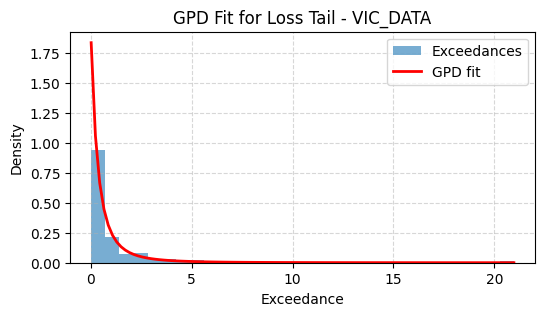

In [9]:
evt_results = fit_evt(std_resids, quantile=0.95)

for ticker, resid in std_resids.items():
    losses = -resid.dropna()
    threshold = evt_results[ticker]['threshold']
    exceedances = losses[losses > threshold] - threshold
    shape = evt_results[ticker]['shape']
    scale = evt_results[ticker]['scale']
    plt.figure(figsize=(6, 3))
    plt.hist(exceedances, bins=30, density=True, alpha=0.6, label='Exceedances')
    x = np.linspace(exceedances.min(), exceedances.max(), 100)
    plt.plot(x, genpareto.pdf(x, shape, loc=0, scale=scale), 'r-', lw=2, label='GPD fit')
    plt.title(f'GPD Fit for Loss Tail - {ticker}')
    plt.xlabel('Exceedance')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()